<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Augusto Tagle Montes

### **Link de repositorio de GitHub:** https://github.com/atagle123/Evaluaciones_MDS7202

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [2]:
!pip install xgboost

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

seed=123

Y=df.loc[:,"Diabetes"]
X=df.drop(['Diabetes'],axis=1)
          
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,shuffle=True, random_state=seed) # se separan los datos
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.222,shuffle=True, random_state=seed)

In [4]:

num_features=["Age","BMI","GenHlth","MentHlth","PhysHlth"]  # features numericos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_features)  # se hace un min max scaler a los features numericos, aunque a los árboles no les afecta la escala de los features.
    ],
    remainder='passthrough'
)


steps = [
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',seed=seed))
]
pipeline_xgb = Pipeline(steps)

pipeline_xgb.fit(X_train, y_train)
y_pred_val = pipeline_xgb.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.75


In [5]:
y_train.value_counts()

Diabetes
1.0    24784
0.0    24713
Name: count, dtype: int64

El clasificador, logra tener un accuracy relativamente bueno al predecir la diabetes, se obtiene un accuracy de 0.75 en el conjunto de validacion, siendo que el dataset esta bastante balanceado (50-50).  
Las métricas de desempeño no nos dicen nada acerca de los features que se elijieron para predecir en el modelo. Las métricas buscan evaluar como predice el modelo ante datos nuevos.


## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

<Axes: title={'center': 'Feature Importance (gain)'}, xlabel='F score', ylabel='Features'>

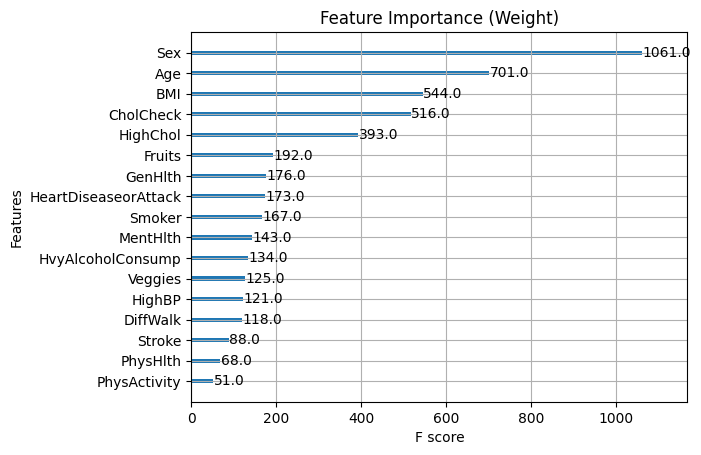

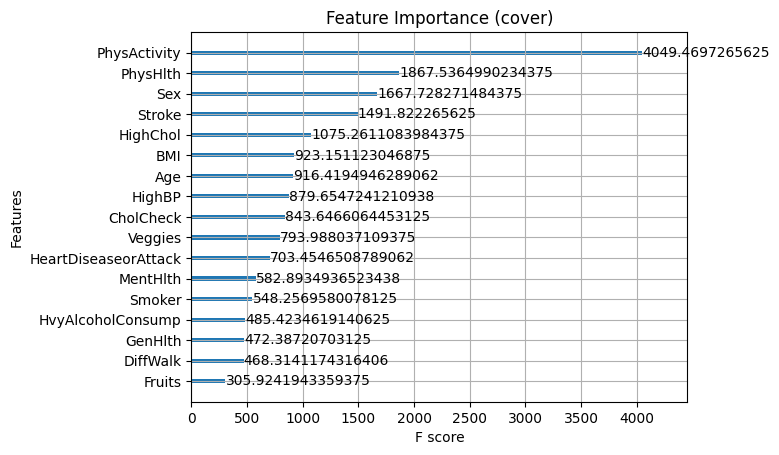

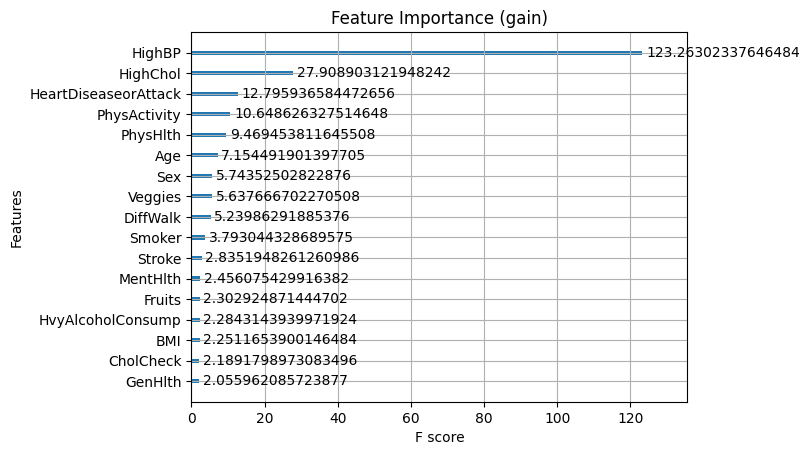

In [6]:
model=pipeline_xgb.named_steps["regressor"]
model.get_booster().feature_names=list(X_train.columns)

xgb.plot_importance(model.get_booster(),importance_type='weight', title='Feature Importance (Weight)')
xgb.plot_importance(model.get_booster(),importance_type='cover', title='Feature Importance (cover)')
xgb.plot_importance(model.get_booster(),importance_type='gain', title='Feature Importance (gain)')



- Se puede ver que los resultados obtenidos con los diferentes métodos no son necesariamente compatibles, pero tienen ciertas similitudes. Por ejemplo: la variable Sex y HighChol (colesterol alto) tienen altas importancias en las diferentes métricas.
- Las importancias obtenidas pueden servir para interpretar un modelo de árboles, sin embargo tienen la debilidad de que las métricas de importancia obtenidas pueden variar drásticamente unas de otras, por lo que no son necesariamente buenas para interpretar un modelo de árbol. Por lo que se debe recurrir a otros métodos.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

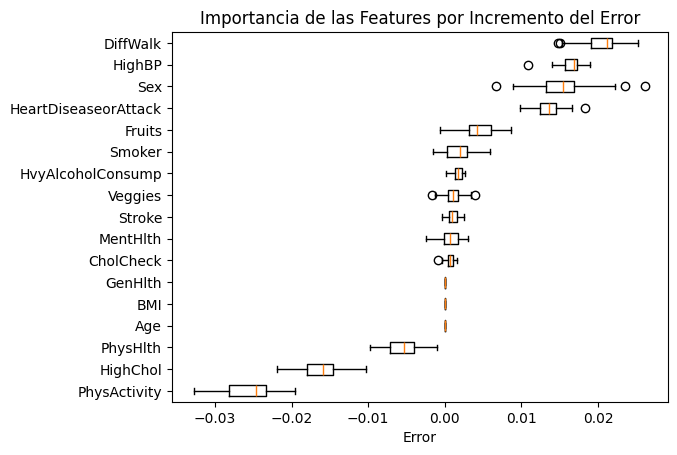

In [7]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt 

result = permutation_importance(pipeline_xgb.named_steps["regressor"], X_test, y_test, n_repeats=30, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(X_test.columns.values)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

Este método permuta las features de los datos y ve como cambia el error, con lo que en base a eso puede determinar la importancia de las features.  
**Las features que tienen mayor impacto son:**
 - Diffwalk: Tiene sentido, ya que esta relacionada con la actividad física.
 - HighBP: Tiene sentido ya que es alta presión sanguinea.
 - Sex: Tiene sentido ya que se refiere al sexo de la persona.
 - HeartDisseaseorAttack: Tiene sentido ya que se refiere a si el paciente ha tenido ataques al corazón. 
 - Fruits: Es la que menos tiene sentido pero podría estar relacionada con la alimentación. 
   

- Se puede observar que existe cierta similitud con los features obtenidos del método anterior.  

**Ventajas del método:**
 - Permite entender la interpretabilidad global.  

 - Es de fácil interpretación.  
 - Se puede aplicar a diferentes modelos y comparar las importancias.    

**Desventajas del método:**
 - Depende en gran medida del error del modelo.  
 
 - Si hay correlación en los features puede generar resultados no esperados por sesgos. 
 - Es costoso computacionalmente, ya que genera permutaciones de los features para calcular las importancias, con muchos features se puede tener problemas.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [8]:
!pip install shap

In [9]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [10]:
import shap
model=pipeline_xgb.named_steps["regressor"]
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

shap_values


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[23:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


.values =
array([[ 0.17694023,  2.2612972 ,  0.86385053, ...,  0.07230723,
        -0.00941527,  0.4532626 ],
       [ 0.2926757 , -1.7685897 , -0.29057923, ..., -0.03786565,
        -0.02182708, -0.7147578 ],
       [ 0.17694023,  2.2612972 ,  0.86385053, ...,  0.07230723,
        -0.00941527,  0.4532626 ],
       ...,
       [ 0.22532994,  2.0157933 , -0.695004  , ...,  0.0054193 ,
         0.00805612, -0.9036042 ],
       [ 0.03436719, -0.31637377,  0.7454477 , ...,  0.632975  ,
        -0.00877834,  0.48062062],
       [ 0.44614953, -0.25080207,  0.10412082, ...,  0.6066313 ,
        -0.03774811,  0.49570212]], dtype=float32)

.base_values =
array([-0.00520206, -0.00520206, -0.00520206, ..., -0.00520206,
       -0.00520206, -0.00520206], dtype=float32)

.data =
array([[ 9.,  1.,  1., ...,  0.,  0.,  1.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  1.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 4.,  1.,  0., ...,  0.,  0.,  0.],
       [10.,  0.,  1., ...,  1.,  0.

En los resultados se tienen los shap values y los shap base values.
Los dos son relevantes para poder interpretar los resultados.  
Los base values entregan contexto sobre los shap values para cada carácteristica.  

La diferencia entre los base values y los values determina si una feature impacta positivamente o negativamente en el modelo.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

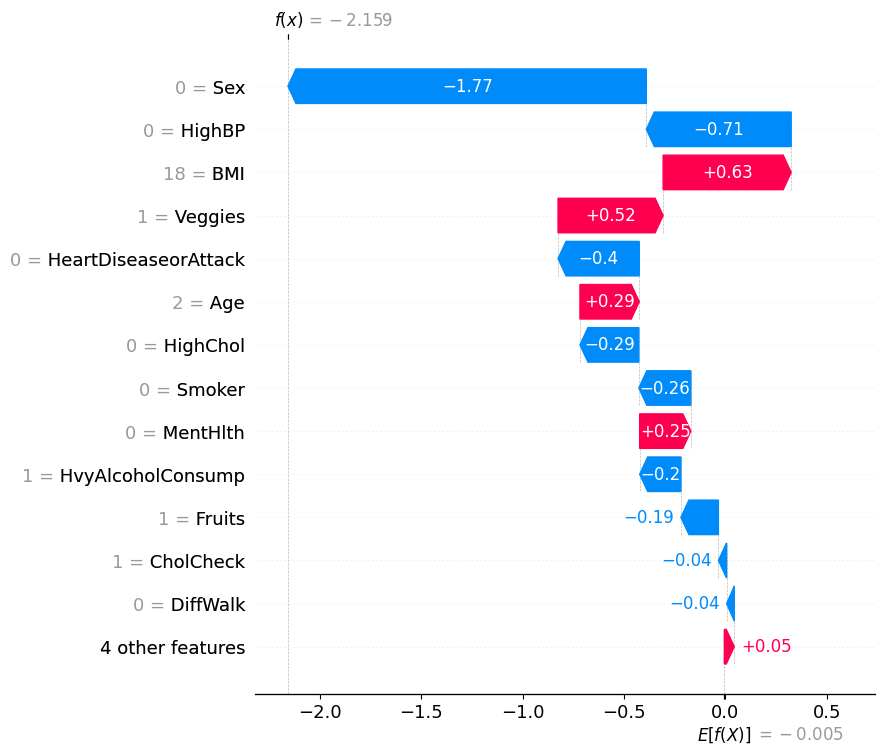

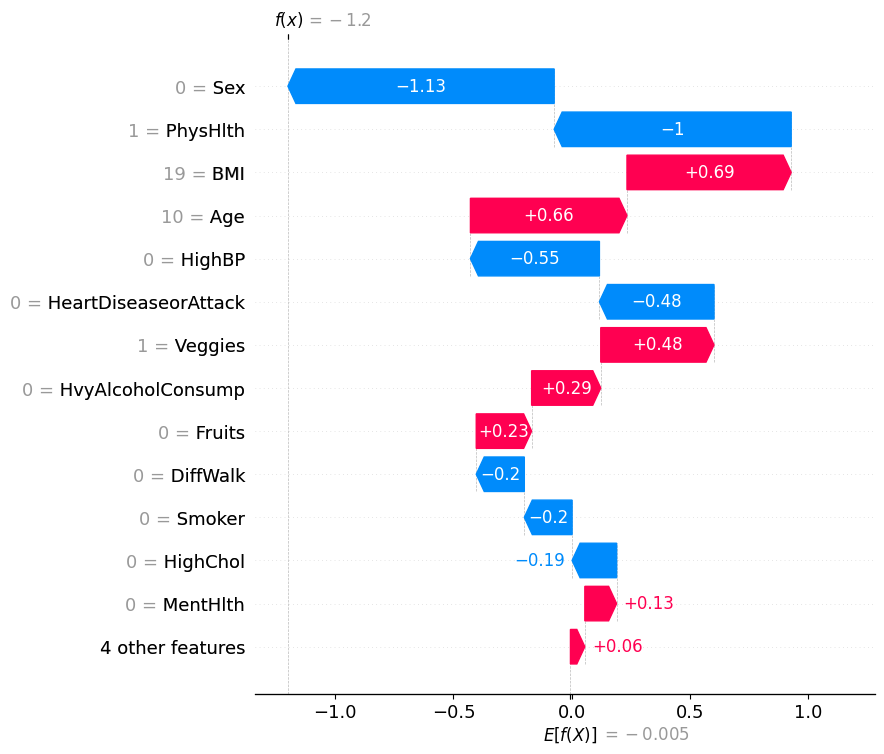

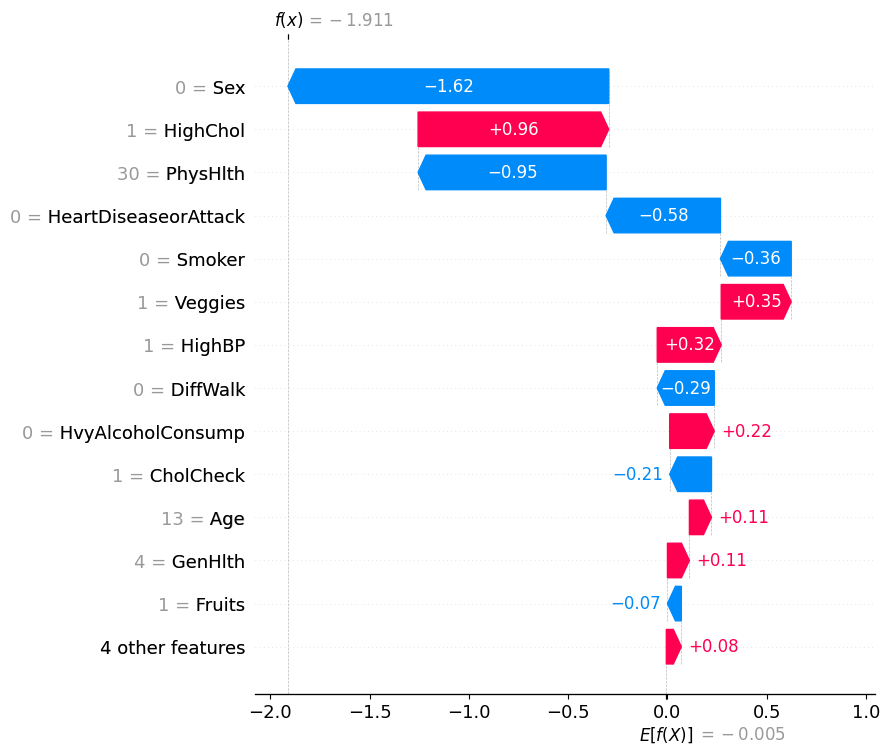

In [11]:
idx=1
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)
idx=9
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)
idx=150
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)
            

Se puede ver que en todos los casos la variable "Sex" afecta de manera negativa al modelo. Tambien Phys health afecat de manera negativa en 2 de 3 instancias. Tambien se puede ver que "BMI" afecta de manera positiva.  
Por lo que se puede ver que existe cierta relación entre las distintas instancias analizadas, aunque hay ciertas diferencias.  
Por lo tanto no se pueden generalizar estos resultados a todo el dataset, se debe observar una gran cantidad de puntos, para poder determinar correctamente como afectan las variables al modelo.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

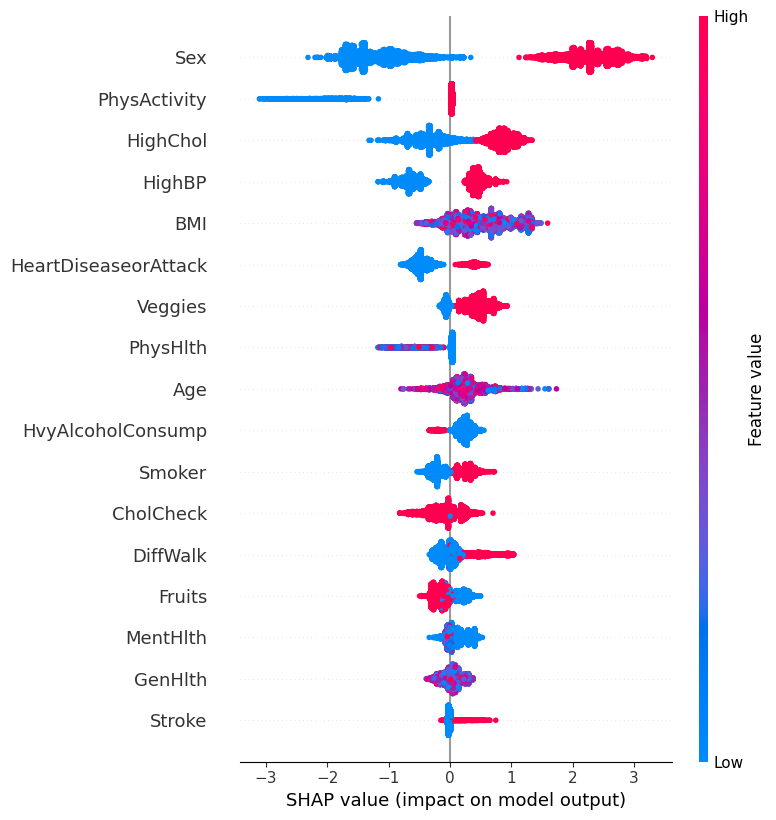

In [12]:
shap.summary_plot(shap_values, X_test)#, plot_type="bar")


Se puede observar que las importancias globales obtenidas son bastante similares a las que se obtuvieron viendo las importancias por instancias. Aunque ahora tambien se puede observar el grado que la variable afecta a la clase. 

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

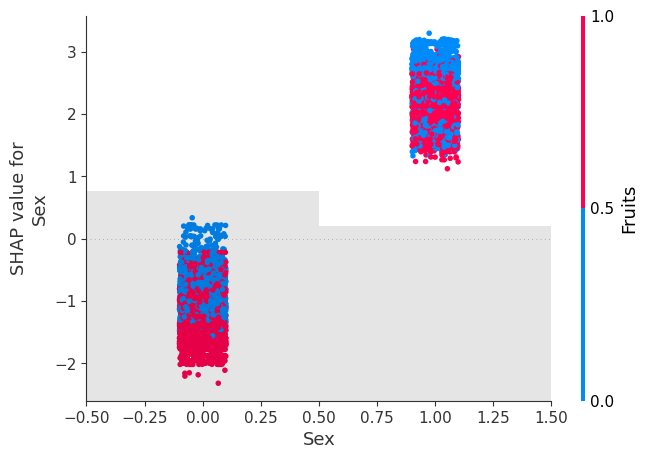

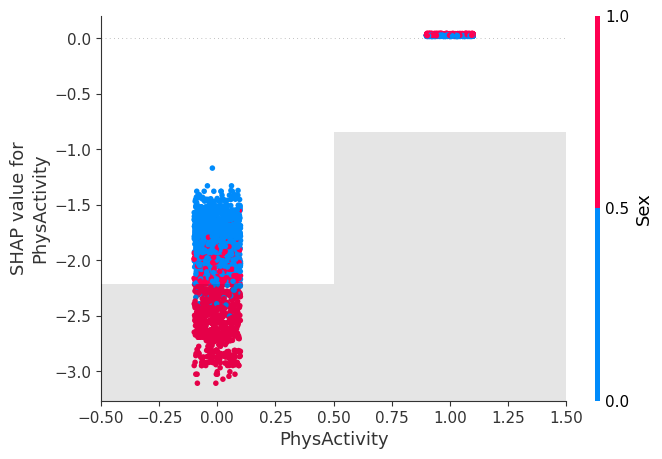

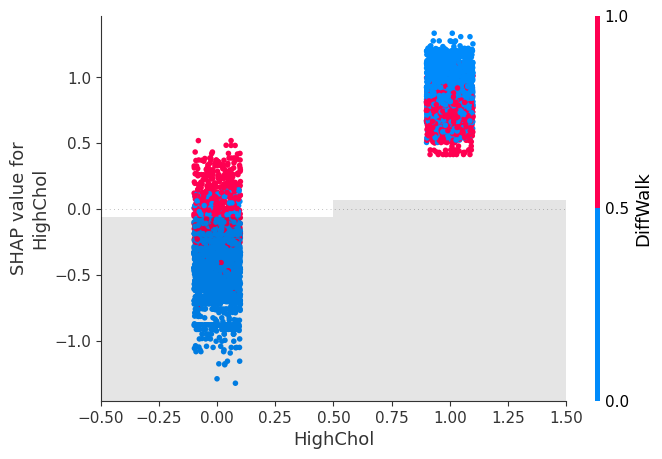

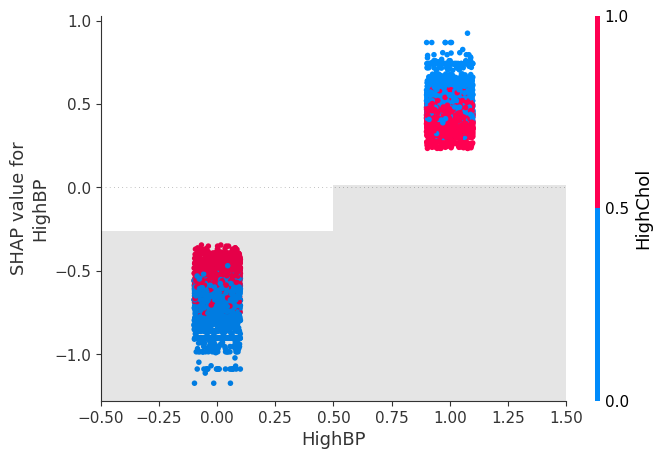

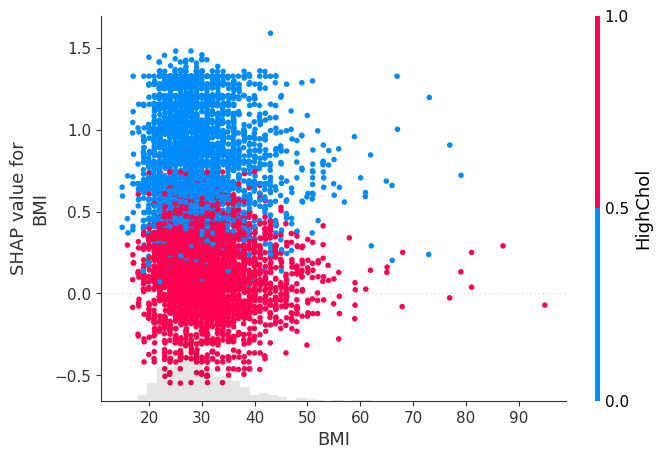

In [13]:
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_test.columns[shap_values_abs.argsort()[::-1]]

for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                   color=shap_values)

A partir de los resultados obtenidos, se puede concluir que estas variables logran una gran separación de las clases dado los SHAP values. Que es lo que se esperaba ya que son las features mas importantes, por lo que deberían tener un buen poder predictivo sobre la clase. 

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

TypeError: Axes.stem() got an unexpected keyword argument 'use_line_collection'

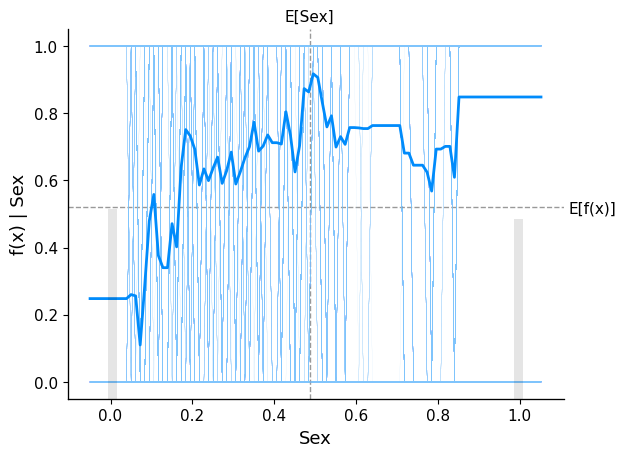

In [14]:
for name in feature_importance_names[:5]:
    X100 = shap.utils.sample(X_test, 1000)
    sample_ind = 1000
    shap.partial_dependence_plot(
        str(name), model.predict, X100, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind:sample_ind+1,:]
    )

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
!pip install alibi

In [45]:
# Inserte su código para generar sistema de reglas aquí
from alibi.explainers import AnchorTabular

model = pipeline_xgb.named_steps['regressor']

predict_fn = lambda x: model.predict(x)

feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns.tolist())
explainer = AnchorTabular(predictor=predict_fn, feature_names=feature_names)
explainer.fit(X_train.values)

idxs_to_explain = [1000, 3001, 5751]
for idx in idxs_to_explain:
    data = X_train.iloc[[idx]]
    explanation = explainer.explain(data.values)
    print(f"Instance {idx}:", explanation.meta())


Instance 1000: Explanation(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': (25, 50, 75),
              'threshold': 0.95,
              'delta': 0.1,
              'tau': 0.15,
              'batch_size': 100,
              'coverage_samples': 10000,
              'beam_size': 1,
              'stop_on_first': False,
              'max_anchor_size': None,
              'min_samples_start': 100,
              'n_covered_ex': 10,
              'binary_cache_size': 10000,
              'cache_margin': 1000,
              'verbose': False,
              'verbose_every': 1,
              'kwargs': {}}
            ,
  'version': '0.9.4'}
, data={
  'anchor': ['num__BMI > 0.00', 'remainder__CholCheck > 0.00'],
  'precision': 1.0,
  'coverage': 0.3355,
  'raw': {
           'feature': [1, 7],
           'mean': [0.8944281524926686, 1.0],
           'precision': [0.8944281524926686, 1.0],

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí:

Las mejores conclusiones acerca la tarea de clasificación de diabetes los entrega los SHAP values, ya que permiten tener interpretabilidad global y local y son agnosticos al modelo. Por lo que se puede tener bastante claridad de como explicar los resultados.

Para el problema del doctor SIMI en mi opinión son mas útiles los métodos agnósticos globales, ya que si bien son una generalización de como afectan las features al modelo, tienen un poder a priori de prevención y de detectar factores de riesgo en el caso de la diabetes. Por lo que podría ser útil para determninar cuando un paciente deba ir a consultar acerca de su diabetes, e incluso evitar ciertos hábitos que puedan ser factores de riesgo. Tambien, los métodos globales ofrecen una explicabilidad mas sencilla, en comparación a los métodos locales.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>